In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2

import skimage.measure

import rasterio
from rasterio.features import shapes

import matplotlib.patches as mpatches
from shapely.geometry import Point, Polygon, shape, mapping
import shapely
import geopandas as gpd

from matplotlib.path import Path
import laspy
import open3d as o3d


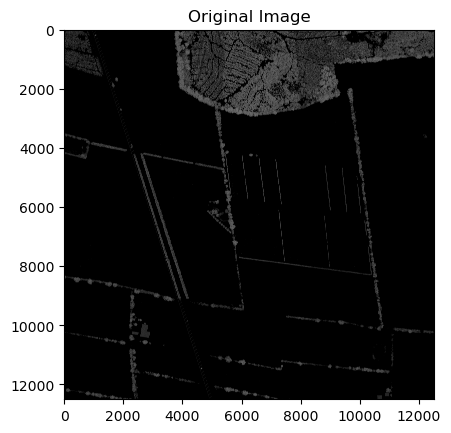

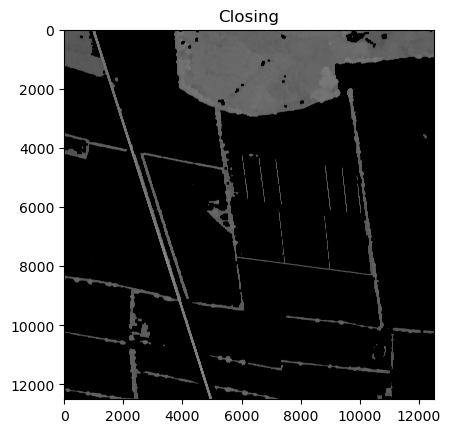

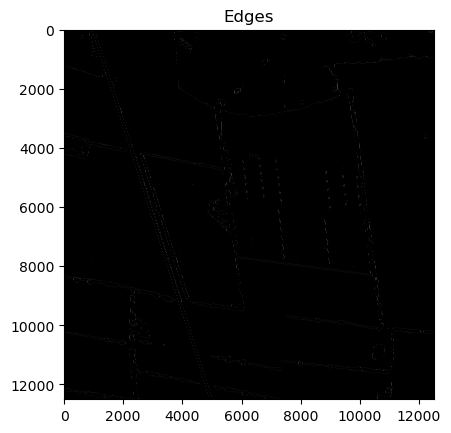

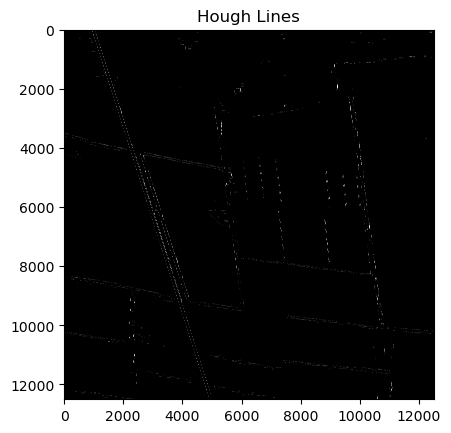

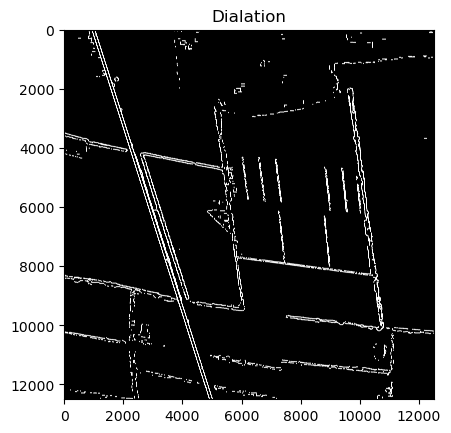

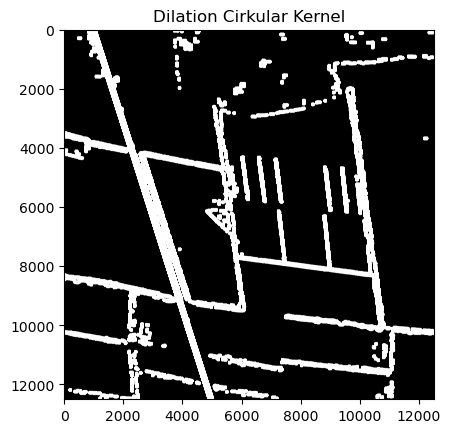

In [2]:
image = cv2.imread('/home/jf/Downloads/WingDownload/PUNKTSKY_00005_1km_6134_518_max.tif', cv2.IMREAD_UNCHANGED)
image = np.where(image >= 0, image, 0)
image = image/np.max(image)

image = (image*255).astype(np.uint8)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.show()

kernel = np.ones((70,70),np.uint8)
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

plt.title("Closing")
plt.imshow(closing, cmap='gray')
plt.show()


#max_pooling = skimage.measure.block_reduce(closing, (10,10), np.max)

#plt.title("Max Pooling")
#plt.imshow(max_pooling, cmap='gray')
#plt.show()


# Apply edge detection method on the image
edges = cv2.Canny(closing, 4, 160, None, 3)

plt.title("Edges")
plt.imshow(edges, cmap='gray')
plt.show()

# Probabilistic Line Transform
# min_line_length, max_line_gap

linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 100)

lines_image = np.zeros_like(image)
# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(lines_image, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3)

plt.title("Hough Lines")
plt.imshow(lines_image, cmap='gray')
plt.show()

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(lines_image, kernel, iterations = 7)
plt.imshow(dilation, cmap='gray')
plt.title("Dialation")
plt.show()


# Pixels per kilometer
x_pixels, y_pixels = image.shape

# Pixels per meter
x_pixels, y_pixels = x_pixels/1000, y_pixels/1000

# Set kernel size to 1 meter around the each line
kernel_size = int(2*np.ceil(x_pixels))*2

# Create kernel
circular_kernel = np.zeros((kernel_size, kernel_size), np.uint8)

# Create a cirkular kernel using (image, center_coordinates, radius, color, thickness)
cv2.circle(circular_kernel, (int(kernel_size/2), int(kernel_size/2)), int(kernel_size/2), 255, -1)

# Perform dilation with the cirkular kernel
dilation_cirkular_kernel = cv2.dilate(dilation, circular_kernel, iterations=2)

plt.title("Dilation Cirkular Kernel")
plt.imshow(dilation_cirkular_kernel, cmap="gray")
plt.show()

In [3]:
# Flipped Polygons

mask = (dilation_cirkular_kernel == 0)
output = rasterio.features.shapes(255-dilation_cirkular_kernel, mask=mask, connectivity=4)
flipped_multipolygons_list = list(output)
print("Amount of multipolygons: ", len(flipped_multipolygons_list))

flipped_polygons_path_unpacked = []
flipped_polygons_unpacked = []

for multi_polygons in flipped_multipolygons_list:
    for polygon in multi_polygons[0]['coordinates']:
        flipped_polygons_path_unpacked.append(Path(polygon))
        flipped_polygons_unpacked.append(Polygon(polygon))

print("Amount of flipped polygons: ", len(flipped_polygons_path_unpacked))

Amount of multipolygons:  93
Amount of flipped polygons:  155


In [8]:
mask = (dilation_cirkular_kernel == 255)
output = rasterio.features.shapes(dilation_cirkular_kernel, mask=mask, connectivity=8)
multipolygons_list = list(output)
#print("Amount of multipolygons: ", len(multipolygons_list))

polygons_path = []
multi_polygons_path =[]

for multi_polygons in multipolygons_list:    
    if len(multi_polygons[0]['coordinates']) == 1:
        
        for polygon in multi_polygons[0]['coordinates']:
            shapely_polygon = Polygon(polygon) 
            shapely_simp_polygon = shapely.simplify(shapely_polygon, tolerance=1, preserve_topology=False)    
            polygons_path.append(Path(mapping(shapely_simp_polygon)['coordinates'][0]))
    else:
        tmpMulti = []
        for polygon in multi_polygons[0]['coordinates']:
            shapely_polygon = Polygon(polygon) 
            shapely_simp_polygon = shapely.simplify(shapely_polygon, tolerance=1, preserve_topology=False)  
            if not shapely_simp_polygon.is_empty:
                tmpMulti.append(Path(mapping(shapely_simp_polygon)['coordinates'][0]))
            
        multi_polygons_path.append(tmpMulti)

print(f"Amount of polygons: {len(polygons_path)}")
print(f"Amount of multi polygons: {len(multi_polygons_path)}")

# polygons_path_unpacked = []
# polygons_unpacked = []
# multi_polygons_unpacked = []
# for multi_polygons in multipolygons_list:
#     for polygon in multi_polygons[0]['coordinates']:
#         polygons_path_unpacked.append(Path(polygon))
#         polygons_unpacked.append(shapely.Polygon(polygon))

# print("Amount of polygons: ", len(polygons_path_unpacked))

Amount of polygons: 70
Amount of multi polygons: 4


In [16]:
len(multi_polygons_path[0])

1

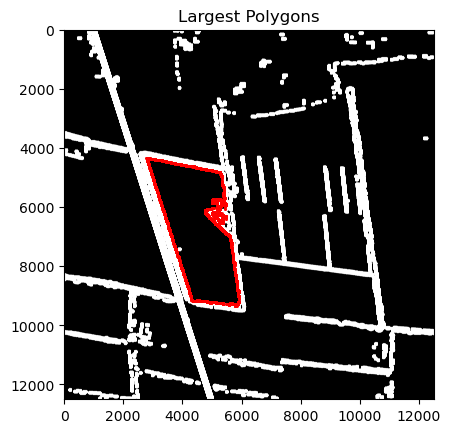

In [5]:
area = [p.area for p in polygons_unpacked]

plt.figure()
plt.imshow(dilation_cirkular_kernel, cmap='gray')
   
x, y = polygons_unpacked[np.argmax(area)+2].exterior.coords.xy
plt.scatter(x,y, s=1, color='red')

    
plt.title("Largest Polygons")
plt.show()


Amount of flipped simplified polygons:  127


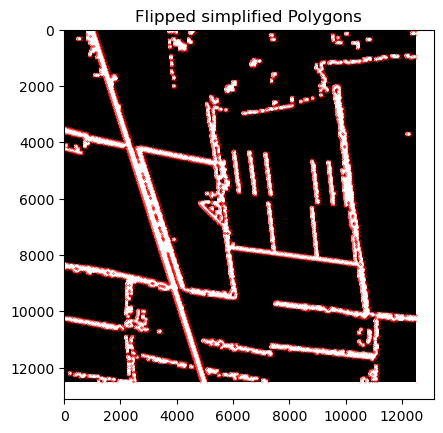

In [6]:
flipped_simplified_polygons = [shapely.simplify(p, tolerance=1, preserve_topology=False) for p in flipped_polygons_unpacked]    
flipped_simplified_polygons  = [p for p in flipped_simplified_polygons if not p.is_empty]

#bbox_polygon = [p for p in polygons_coord if p.area >600]
print("Amount of flipped simplified polygons: ", len(flipped_simplified_polygons))
    
plt.figure()
plt.imshow(dilation_cirkular_kernel, cmap='gray')

for p in flipped_simplified_polygons:
    x, y = p.exterior.coords.xy
    plt.scatter(x,y, s=0.01, color='red')
    
plt.title("Flipped simplified Polygons")
plt.show()


Amount of simplified polygons:  130


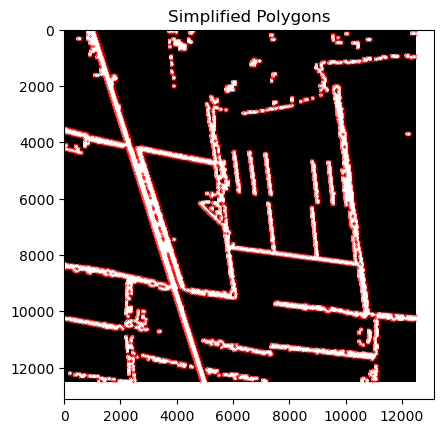

In [7]:
simplified_polygons = [shapely.simplify(p, tolerance=1, preserve_topology=False) for p in polygons_unpacked]    
simplified_polygons  = [p for p in simplified_polygons if not p.is_empty]

print("Amount of simplified polygons: ", len(simplified_polygons))
    
plt.figure()
plt.imshow(dilation_cirkular_kernel, cmap='gray')
i = 0
for p in simplified_polygons:
    x, y = p.exterior.coords.xy
    plt.scatter(x,y, s=0.01, color='red')

    
plt.title("Simplified Polygons")
plt.show()



In [8]:
area = [p.area for p in simplified_polygons]


The polygon with largest area is 72


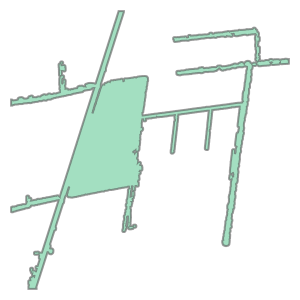

In [9]:
print(f"The polygon with largest area is {np.argmax(area)}")
simplified_polygons[np.argmax(area)]


Amount of simplified polygons:  130


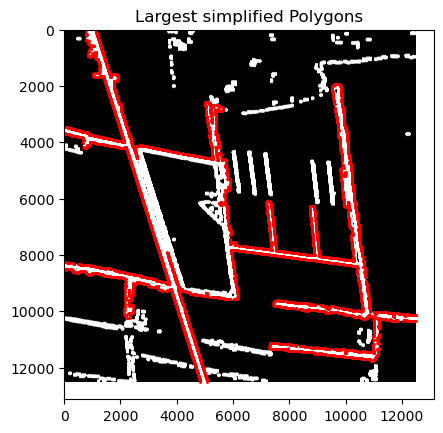

In [10]:
print("Amount of simplified polygons: ", len(simplified_polygons))
    
plt.figure()
plt.imshow(dilation_cirkular_kernel, cmap='gray')
i = 0
x, y = simplified_polygons[np.argmax(area)].exterior.coords.xy
plt.scatter(x,y, s=1, color='red')

    
plt.title("Largest simplified Polygons")
plt.show()


In [11]:
#print(simplified_polygons[0].exterior.coords.xy)
#polygons_path_unpacked[0]
# print(simplified_polygons[0].exterior.coords.xy)
# simplified_polygons[0]


In [12]:
# from shapely.ops import unary_union
# import geopandas as gpd
# mergedPolys = unary_union(simplified_polygons)
# polygons = mergedPolys.geoms
# len(polygons)
# plt.figure()
# plt.imshow(dilation_cirkular_kernel, cmap='gray')
# gpd.GeoSeries([mergedPolys]).boundary.plot()
# plt.show()

In [13]:
# Create Path Polygons
bbox_polygon = [p.bounds for p in simplified_polygons]

simplified_path_polygons = []
bbox_path_polygons = []

for i in range(len(bbox_polygon)):
    
    tempBox = bbox_polygon[i]
    #(minx, miny, maxx, maxy)
    x_min = tempBox[0]
    x_max = tempBox[2]
    
    y_min = tempBox[1]
    y_max = tempBox[3]
    
    bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
    bbox_path_polygons.append(Path(bb))
    
    tempPolygon = simplified_polygons[i]
    simplified_path_polygons.append(Path(mapping(simplified_polygons[i])['coordinates'][0]))

In [18]:
# Pixels per kilometer
x_pixels, y_pixels = image.shape

def MaxMinNormalize(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return MaxMinNormalize(arr)*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

In [19]:
las = laspy.read(r'/home/jf/Downloads/WingDownload/PUNKTSKY_00005_1km_6134_518.laz', laz_backend=laspy.compression.LazBackend.LazrsParallel)
#list(las.point_format.dimension_names)

4095


In [20]:
x_values = CastAllXValuesToImage(las.X, x_pixels)
y_values = CastAllYValuesToImage(las.Y, y_pixels)

# Format: [(1,1), (3,5), (1,5), ...] with 30 mio samples
list_zipped = np.array(list(zip(x_values,y_values)))



In [21]:
# Mask to obtain the final indexes of the las file
#indexes_needed_iter1 = np.zeros(len(x_values), dtype=bool)

indexes_needed = np.zeros(len(x_values), dtype=bool)
indexes_not_needed = np.zeros(len(x_values), dtype=bool)

# print("Reg poly")
# # Run through all polygons and check which points are inside the polygon
# for i in range(len(polygons_path)):
#     indexes_in_poplygon = polygons_path[i].contains_points(list_zipped)
#     indexes_needed = indexes_needed | indexes_in_poplygon
#     print(i)


print("Multi poly")
# Run through all polygons and check which points are inside the polygon
for i in range(len(multi_polygons_path)):
    gg = multi_polygons_path[i][0]
    bg = multi_polygons_path[i][1:]

    good_index = gg.contains_points(list_zipped)
    indexes_not_needed = np.zeros(len(x_values), dtype=bool)
    for b in bg:
        print("here")
        bad_index = b.contains_points(list_zipped)
        indexes_not_needed = indexes_not_needed | bad_index


    needed_index = good_index & np.invert(indexes_not_needed)
    indexes_needed = indexes_needed | needed_index
    
    # indexes_in_polygon = simplified_path_polygons[i].contains_points(list_zipped)
    # indexes_needed = indexes_needed | indexes_in_polygon
    print(i)

Multi poly
0
here
here
1
here


In [ ]:
x_values = CastAllXValuesToImage(las.X, x_pixels)
y_values = CastAllYValuesToImage(las.Y, y_pixels)

# Format: [(1,1), (3,5), (1,5), ...] with 30 mio samples
list_zipped = np.array(list(zip(x_values,y_values)))

# Mask to obtain the final indexes of the las file
#indexes_needed_iter1 = np.zeros(len(x_values), dtype=bool)

indexes_needed = np.zeros(len(x_values), dtype=bool)

print(len(bbox_path_polygons))

# Run through all polygons and check which points are inside the polygon
for i in range(len(bbox_path_polygons)):
    indexes_in_bb = bbox_path_polygons[i].contains_points(list_zipped)
    indexes_needed = indexes_needed | indexes_in_bb
    coordinates_in_bb = list_zipped[indexes_in_bb]
    
    # indexes_in_polygon = simplified_path_polygons[i].contains_points(list_zipped)
    # indexes_needed = indexes_needed | indexes_in_polygon
    print(i)


130
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129


In [ ]:
print("Point Cloud points: ", np.sum(indexes_needed))
new_las = las[indexes_needed]

point_data = np.stack([new_las.X, new_las.Y, new_las.Z], axis=0).transpose((1, 0))

geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

Point Cloud points:  16013095


In [ ]:
print("Point Cloud points: ", np.sum(indexes_needed))

Point Cloud points:  16013095


In [ ]:
point_data = np.stack([las.X, las.Y], axis=0).transpose((1, 0))

In [ ]:
list_zipped

array([[  203.01624,  1275.22701],
       [  192.5154 ,  1276.3521 ],
       [  198.14085,  1274.85198],
       ...,
       [12247.85475, 11492.41932],
       [12251.23002, 11492.29431],
       [12254.60529, 11492.1693 ]])

In [ ]:

#point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))

#geom = o3d.geometry.PointCloud()
#geom.points = o3d.utility.Vector3dVector(point_data)
#o3d.visualization.draw_geometries([geom])